In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

In [103]:
model_no_contrast_path = f"{MODEL_BASE_DIR}/new_api/testBIOSNAP-noContrast_best_model.pt"
model_contrast_path = f"{MODEL_BASE_DIR}/new_api/testBIOSNAP_best_model.pt"
# model_no_contrast_path = f"{MODEL_BASE_DIR}/production_bdb_noContrast_best_model.pt"
# model_contrast_path = f"{MODEL_BASE_DIR}/production_bdb_best_model.pt"

In [104]:
# Load model
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
from src.architectures import SimpleCoembedding

# Set device
device = torch.device(5)

# Load featurizers
mol_f = MorganFeaturizer().cuda(device)
prot_f = ProtBertFeaturizer().cuda(device)

# Load model
model_noCon = SimpleCoembedding(mol_f.shape, prot_f.shape, 1024).to(device)
model_Con = SimpleCoembedding(mol_f.shape, prot_f.shape, 1024).to(device)

model_noCon.load_state_dict(torch.load(model_no_contrast_path))
model_Con.load_state_dict(torch.load(model_contrast_path))

<All keys matched successfully>

## Fit PCA on Drug Landscape

In [105]:
from sklearn.decomposition import PCA

pca_object_nocontrast = PCA()
pca_object_contrast = PCA()

In [106]:
smiles_uniq = set()

for dn in ['BindingDB','DAVIS','BIOSNAP/full_data']:
    data_dir = f"{BASE_DIR}/dataset/{dn}"
    for sub in ['train','val','test']:
        df = pd.read_csv(f"{data_dir}/{sub}.csv",index_col=0)
        smiles_uniq = smiles_uniq.union(df.SMILES)

In [107]:
nocon_projections = []
con_projections = []

for smi in tqdm(list(smiles_uniq),total=len(list(smiles_uniq))):
    mol_emb = mol_f(smi).unsqueeze(0)
    proj_nocon = model_noCon.drug_projector(mol_emb).squeeze().detach().cpu().numpy()
    proj_con = model_Con.drug_projector(mol_emb).squeeze().detach().cpu().numpy()
    
    nocon_projections.append(proj_nocon)
    con_projections.append(proj_con)

  0%|          | 0/11724 [00:00<?, ?it/s]

[15:51:19] Explicit valence for atom # 22 N, 4, is greater than permitted
rdkit not found this smiles for morgan: None convert to all 0 features
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
[15:51:25] Explicit valence for atom # 22 N, 4, is greater than permitted
rdkit not found this smiles for morgan: None convert to all 0 features
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type NoneType
[15:51:31] Explicit valence for atom # 22 N, 4, is greater than permitted
rdkit not found this smiles for morgan: None convert to all 0 features
No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python obje

In [108]:
pca_background_nocontrast = pca_object_nocontrast.fit_transform(np.stack(nocon_projections))
pca_background_contrast = pca_object_contrast.fit_transform(np.stack(con_projections))

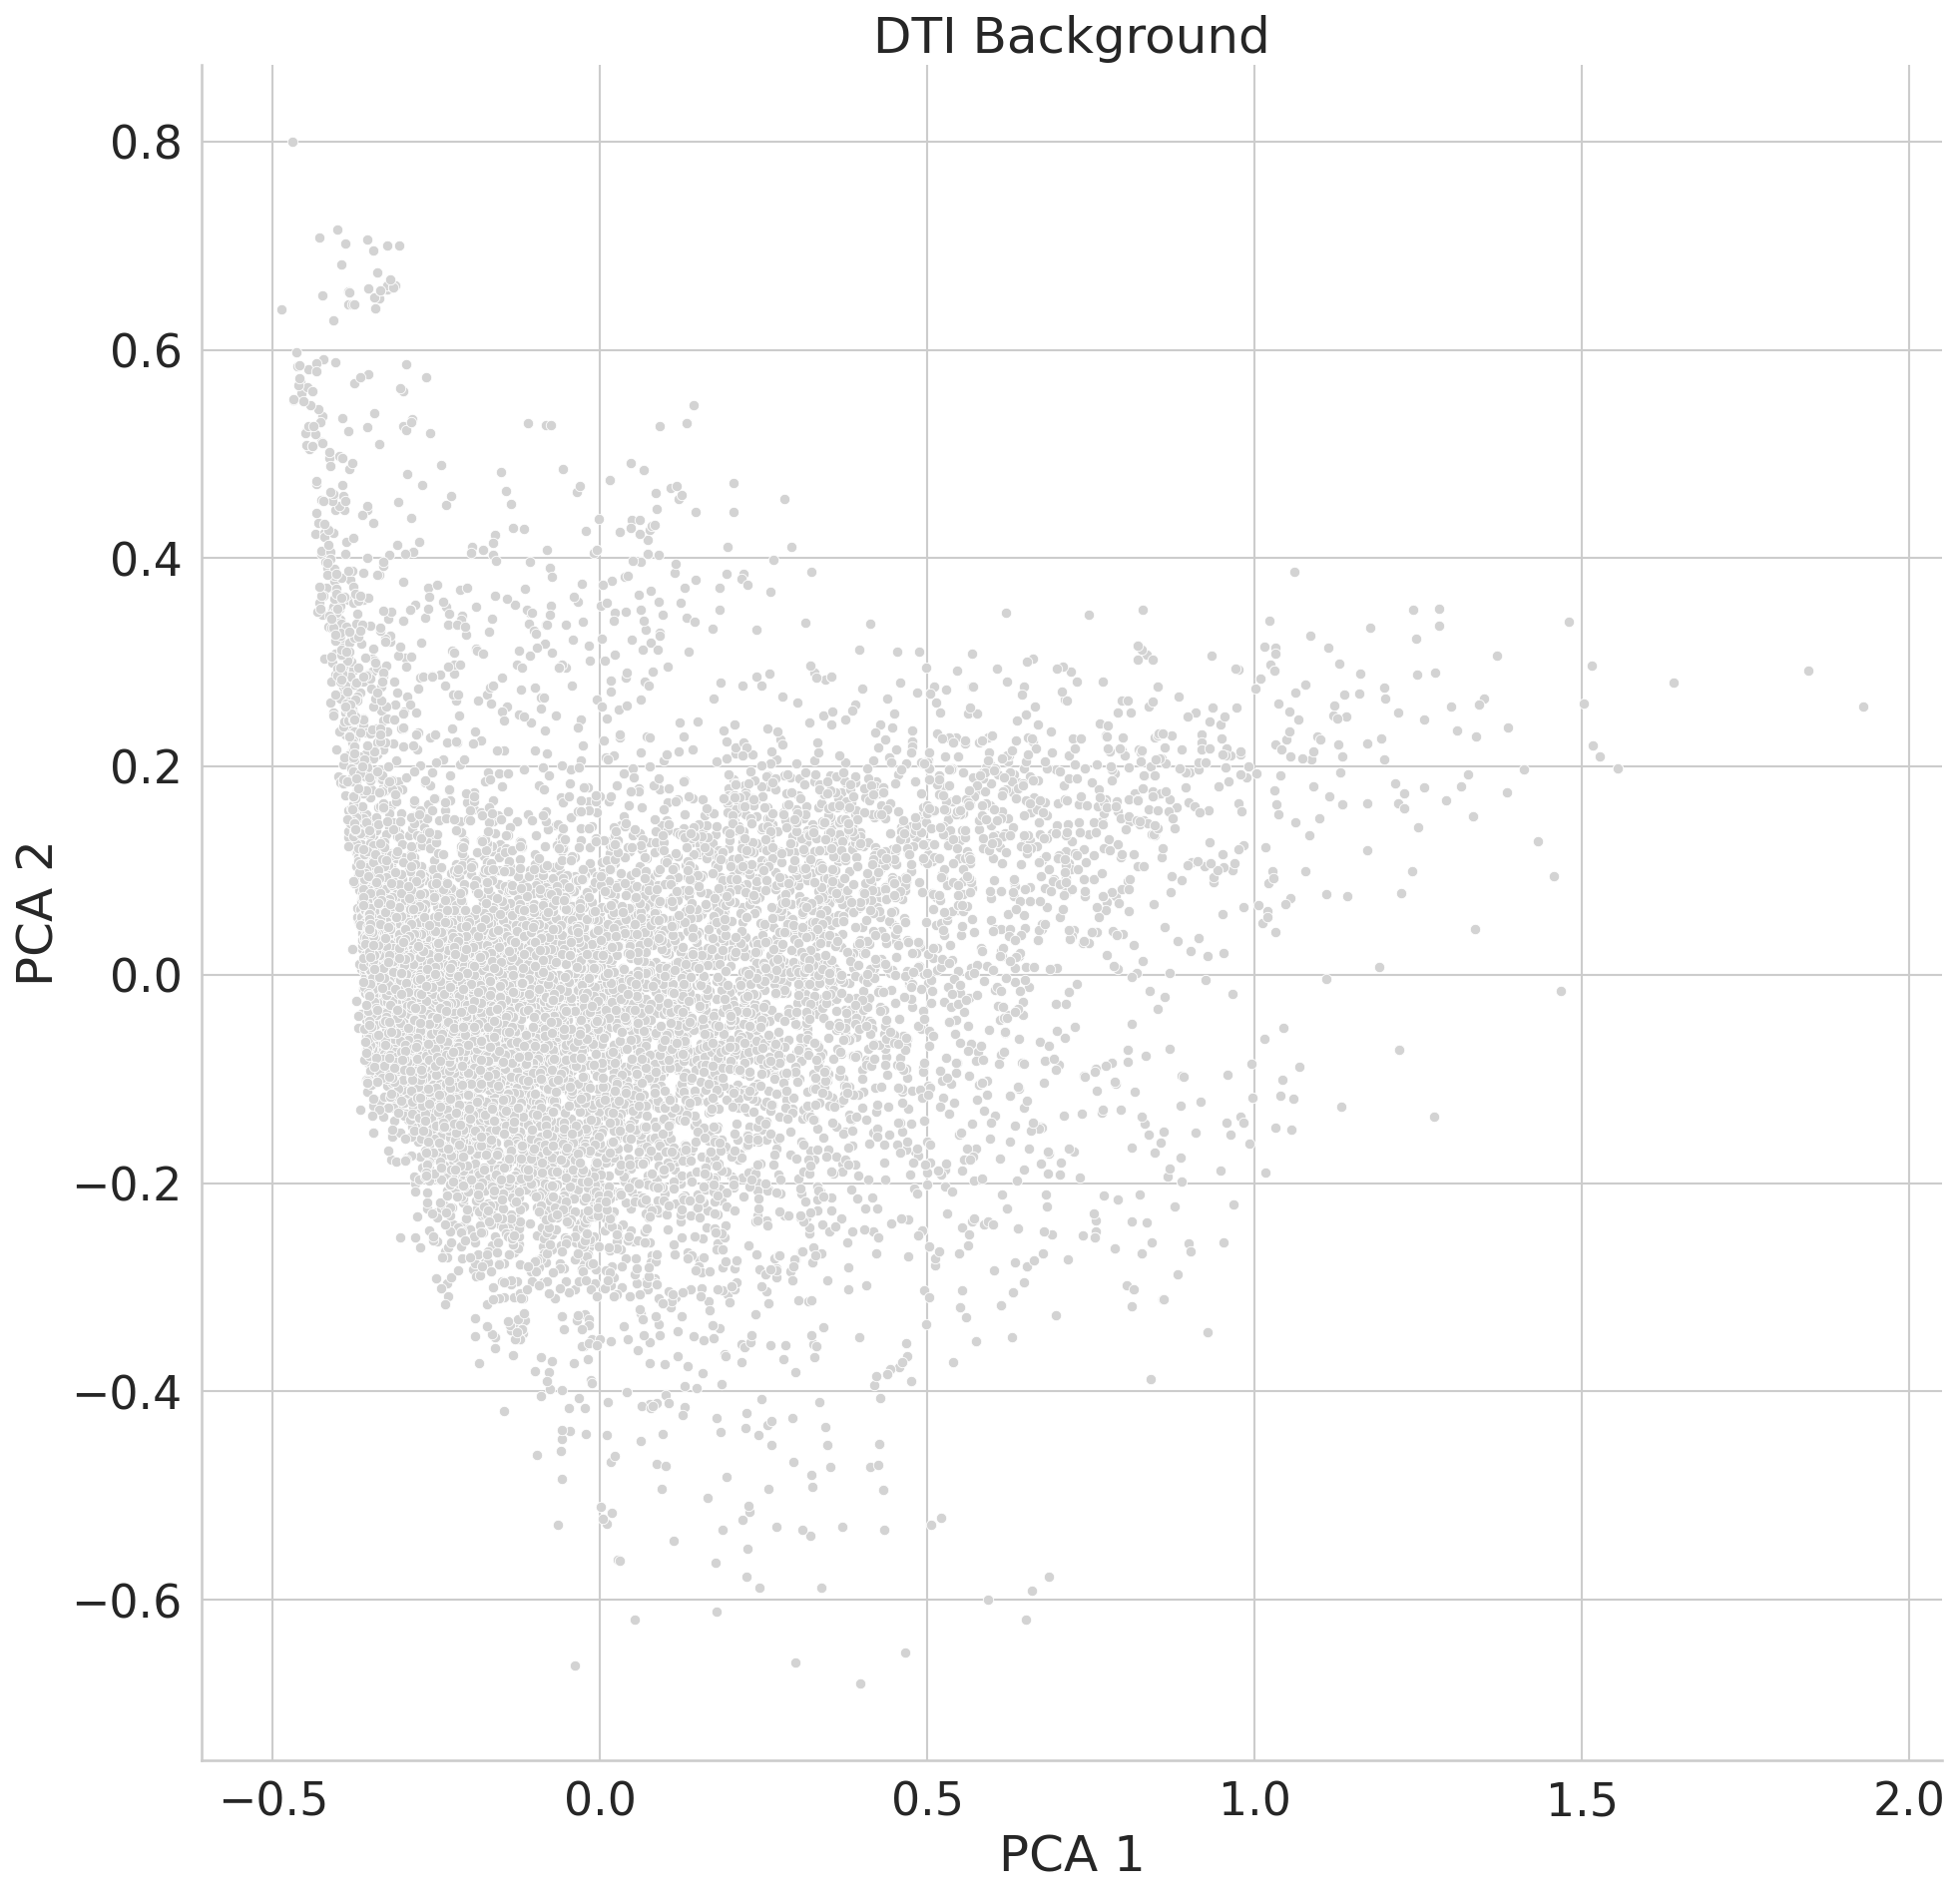

In [200]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(15, 15), dpi=150)

plot_df = pd.DataFrame({
    'PCA 1': pca_background_nocontrast[:,0],
    'PCA 2': pca_background_nocontrast[:,1],
})

sns.scatterplot(
    data = plot_df,
    x = "PCA 1",
    y = "PCA 2",
    color = 'lightgrey',
    # hue = 'Almen Class',
    s=25,
    alpha=1,
   )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('DTI Background')
sns.despine()
plt.show()

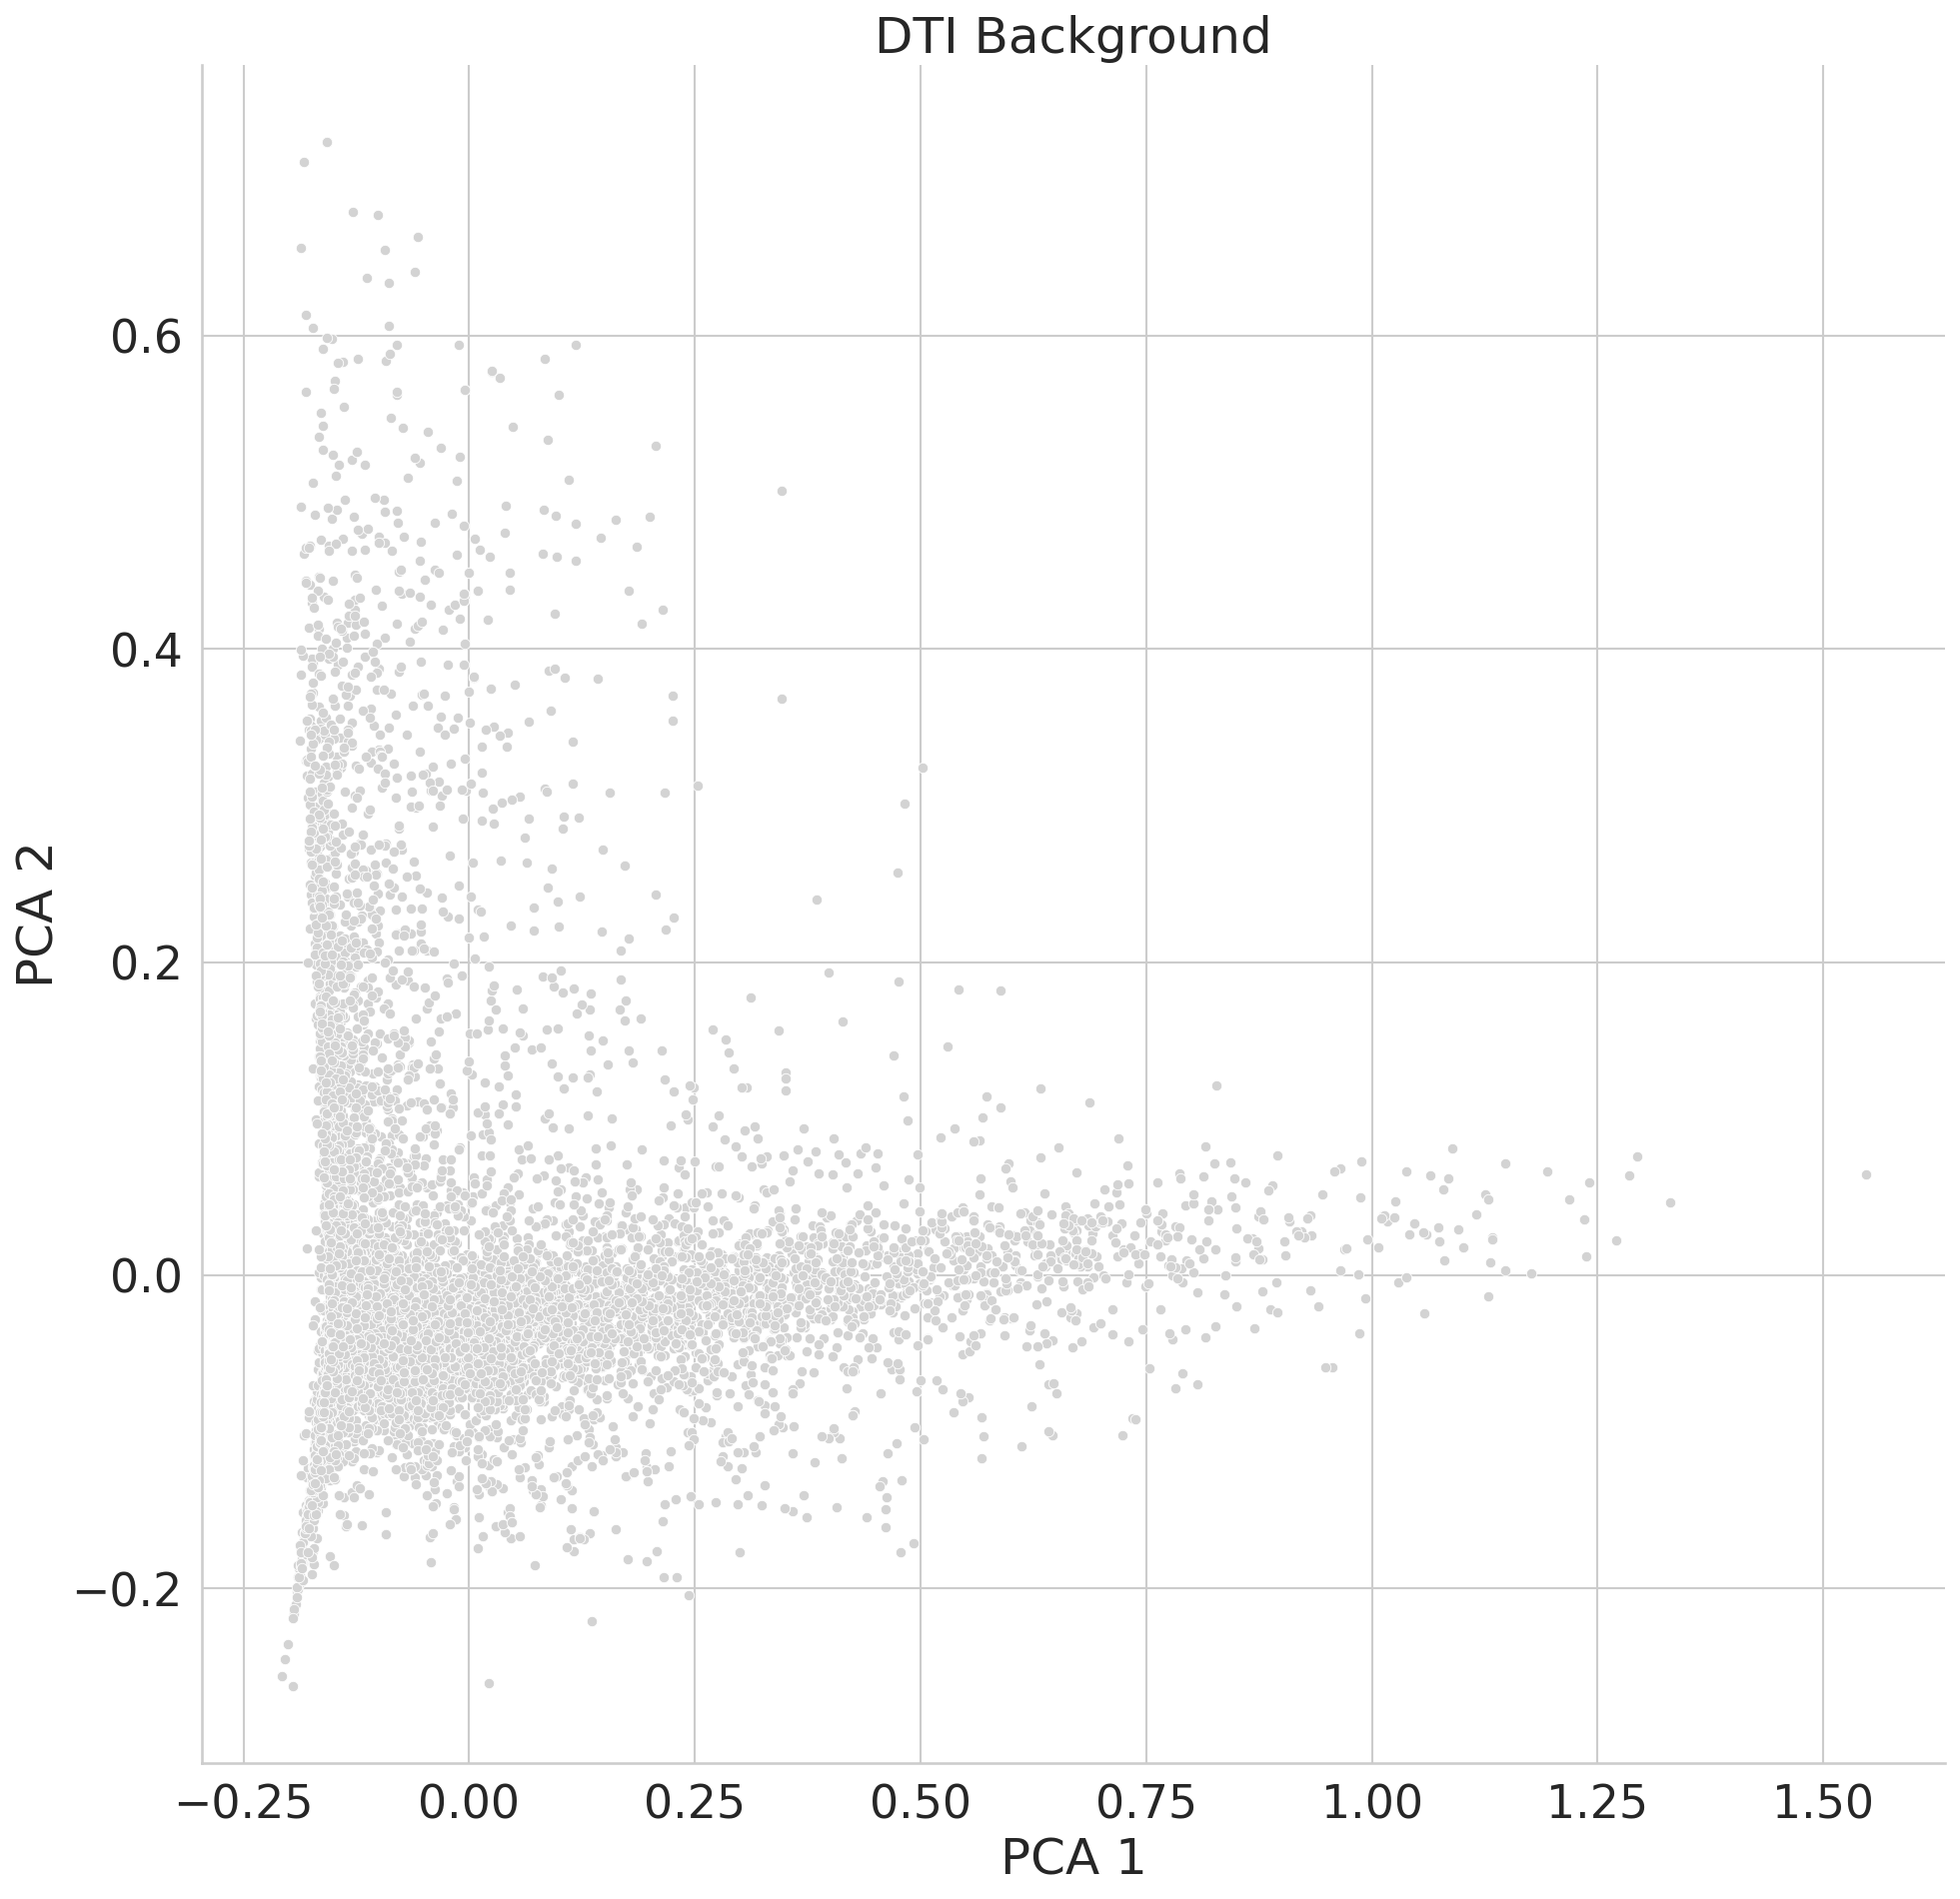

In [201]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(15, 15), dpi=150)

plot_df = pd.DataFrame({
    'PCA 1': pca_background_contrast[:,0],
    'PCA 2': pca_background_contrast[:,1],
})

sns.scatterplot(
    data = plot_df,
    x = "PCA 1",
    y = "PCA 2",
    color = 'lightgrey',
    # hue = 'Almen Class',
    s=25,
    alpha=1,
   )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('DTI Background')
sns.despine()
plt.show()

## Plot a target against the background

In [161]:
from IPython.display import display

In [134]:
target = 'src'

In [135]:
from Bio import SeqIO

def get_sequence_from_pdb(target_path):
    warnings.filterwarnings('ignore')
    recs = list(SeqIO.parse(target_path, "pdb-atom"))
    return recs[0]

seq = str(get_sequence_from_pdb(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/receptor.pdb').seq)

In [136]:
actives = Chem.SDMolSupplier(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/actives_final.sdf')
decoys = Chem.SDMolSupplier(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/decoys_final.sdf')

In [184]:
from rdkit.Chem.Draw import rdMolDraw2D
import IPython.display

In [198]:
for i, am in enumerate(list(actives)[:5]):
    # display(am)
    d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d.DrawMolecule(am)
    d.FinishDrawing()
    p = d.GetDrawingText()
    with open(f'../nbdata/{target}_active{i}.png','wb+') as f:
        f.write(p)
    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    d.DrawMolecule(am)
    d.FinishDrawing()
    p = d.GetDrawingText()
    with open(f'../nbdata/{target}_decoy{i}.svg','wb+') as f:
        f.write(p.encode('utf-8'))

In [199]:
for i, dm in enumerate(list(decoys)[:5]):
    d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d.DrawMolecule(dm)
    d.FinishDrawing()
    p = d.GetDrawingText()
    with open(f'../nbdata/{target}_decoy{i}.png','wb+') as f:
        f.write(p)
    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    d.DrawMolecule(dm)
    d.FinishDrawing()
    p = d.GetDrawingText()
    with open(f'../nbdata/{target}_decoy{i}.svg','wb+') as f:
        f.write(p.encode('utf-8'))

In [137]:
active_nocon = []
active_con = []
decoy_nocon = []
decoy_con = []

with torch.set_grad_enabled(False):
    for m in tqdm(actives):
        m_emb = mol_f(Chem.MolToSmiles(m)).unsqueeze(0)
        active_nocon.append(model_noCon.drug_projector(m_emb).squeeze().detach().cpu().numpy())
        active_con.append(model_Con.drug_projector(m_emb).squeeze().detach().cpu().numpy())
    for m in tqdm(decoys):
        try:
            m_emb = mol_f(Chem.MolToSmiles(m)).unsqueeze(0)
            decoy_nocon.append(model_noCon.drug_projector(m_emb).squeeze().detach().cpu().numpy())
            decoy_con.append(model_Con.drug_projector(m_emb).squeeze().detach().cpu().numpy())
        except Exception as e:
            continue
    seq_nocon = model_noCon.target_projector(prot_f(str(seq)).cuda()).cpu().numpy()
    seq_con = model_Con.target_projector(prot_f(str(seq)).cuda()).cpu().numpy()

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/34959 [00:00<?, ?it/s]

In [138]:
all_dude_nocon = np.stack(active_nocon + decoy_nocon + [seq_nocon])
all_dude_con = np.stack(active_con + decoy_con + [seq_con])

pca_foreground_nocon = pca_object_nocontrast.transform(np.stack(all_dude_nocon))
pca_foreground_con = pca_object_nocontrast.transform(np.stack(all_dude_con))

In [139]:
from sklearn.manifold import TSNE

nocon_tsne_object = TSNE()
con_tsne_object = TSNE()

In [140]:
nocon_tsne_proj = nocon_tsne_object.fit_transform(all_dude_nocon)
con_tsne_proj = con_tsne_object.fit_transform(all_dude_con)

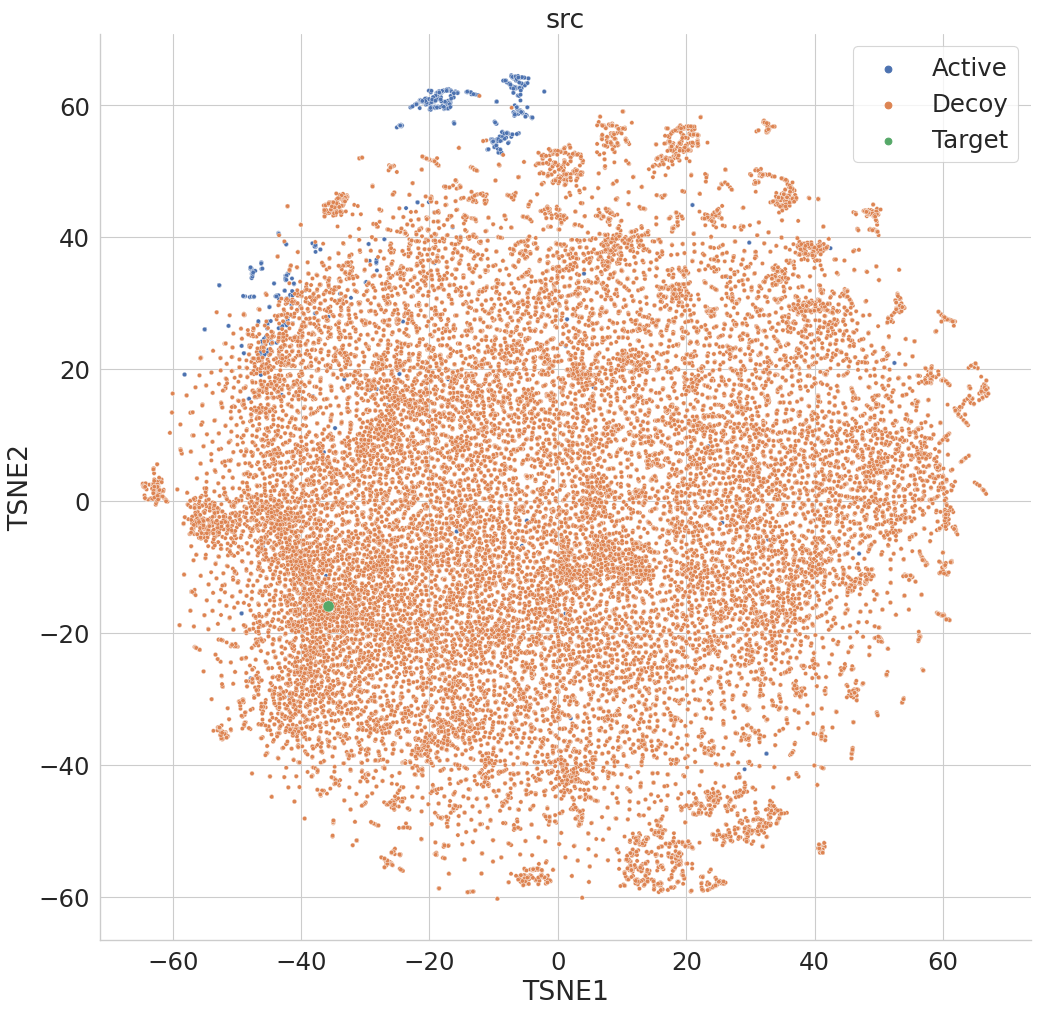

In [141]:
hue = ['Active']*len(active_nocon)+['Decoy']*len(decoy_nocon) + ['Target']
size = [15]*len(active_nocon)+[15]*len(decoy_nocon) + [100]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(x=nocon_tsne_proj[:,0],
                y=nocon_tsne_proj[:,1],
                hue=hue,
                s=size
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title(f'{target}')
sns.despine()
plt.show()

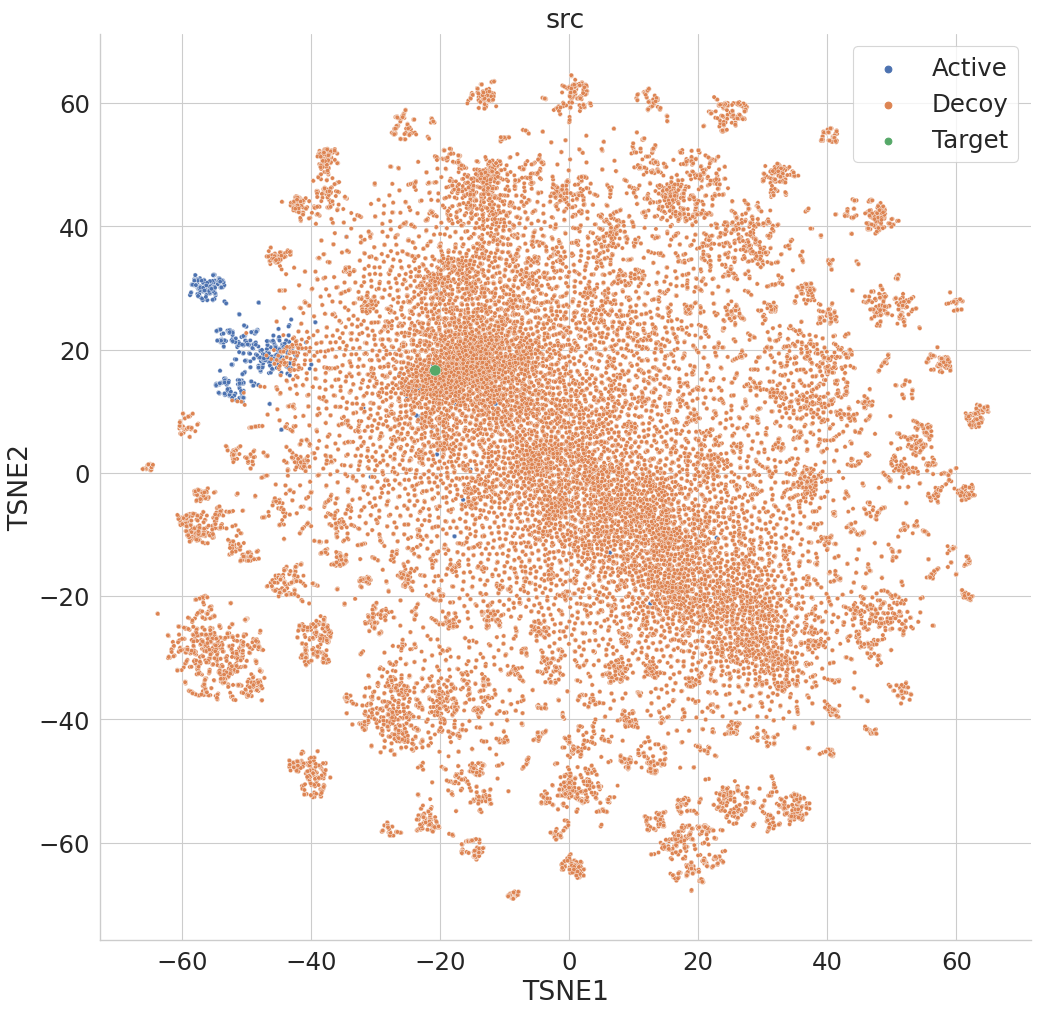

In [142]:
hue = ['Active']*len(active_con)+['Decoy']*len(decoy_con) + ['Target']
size = [15]*len(active_con)+[15]*len(decoy_con) + [100]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(x=con_tsne_proj[:,0],
                y=con_tsne_proj[:,1],
                hue=hue,
                s=size
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title(f'{target}')
sns.despine()
plt.show()

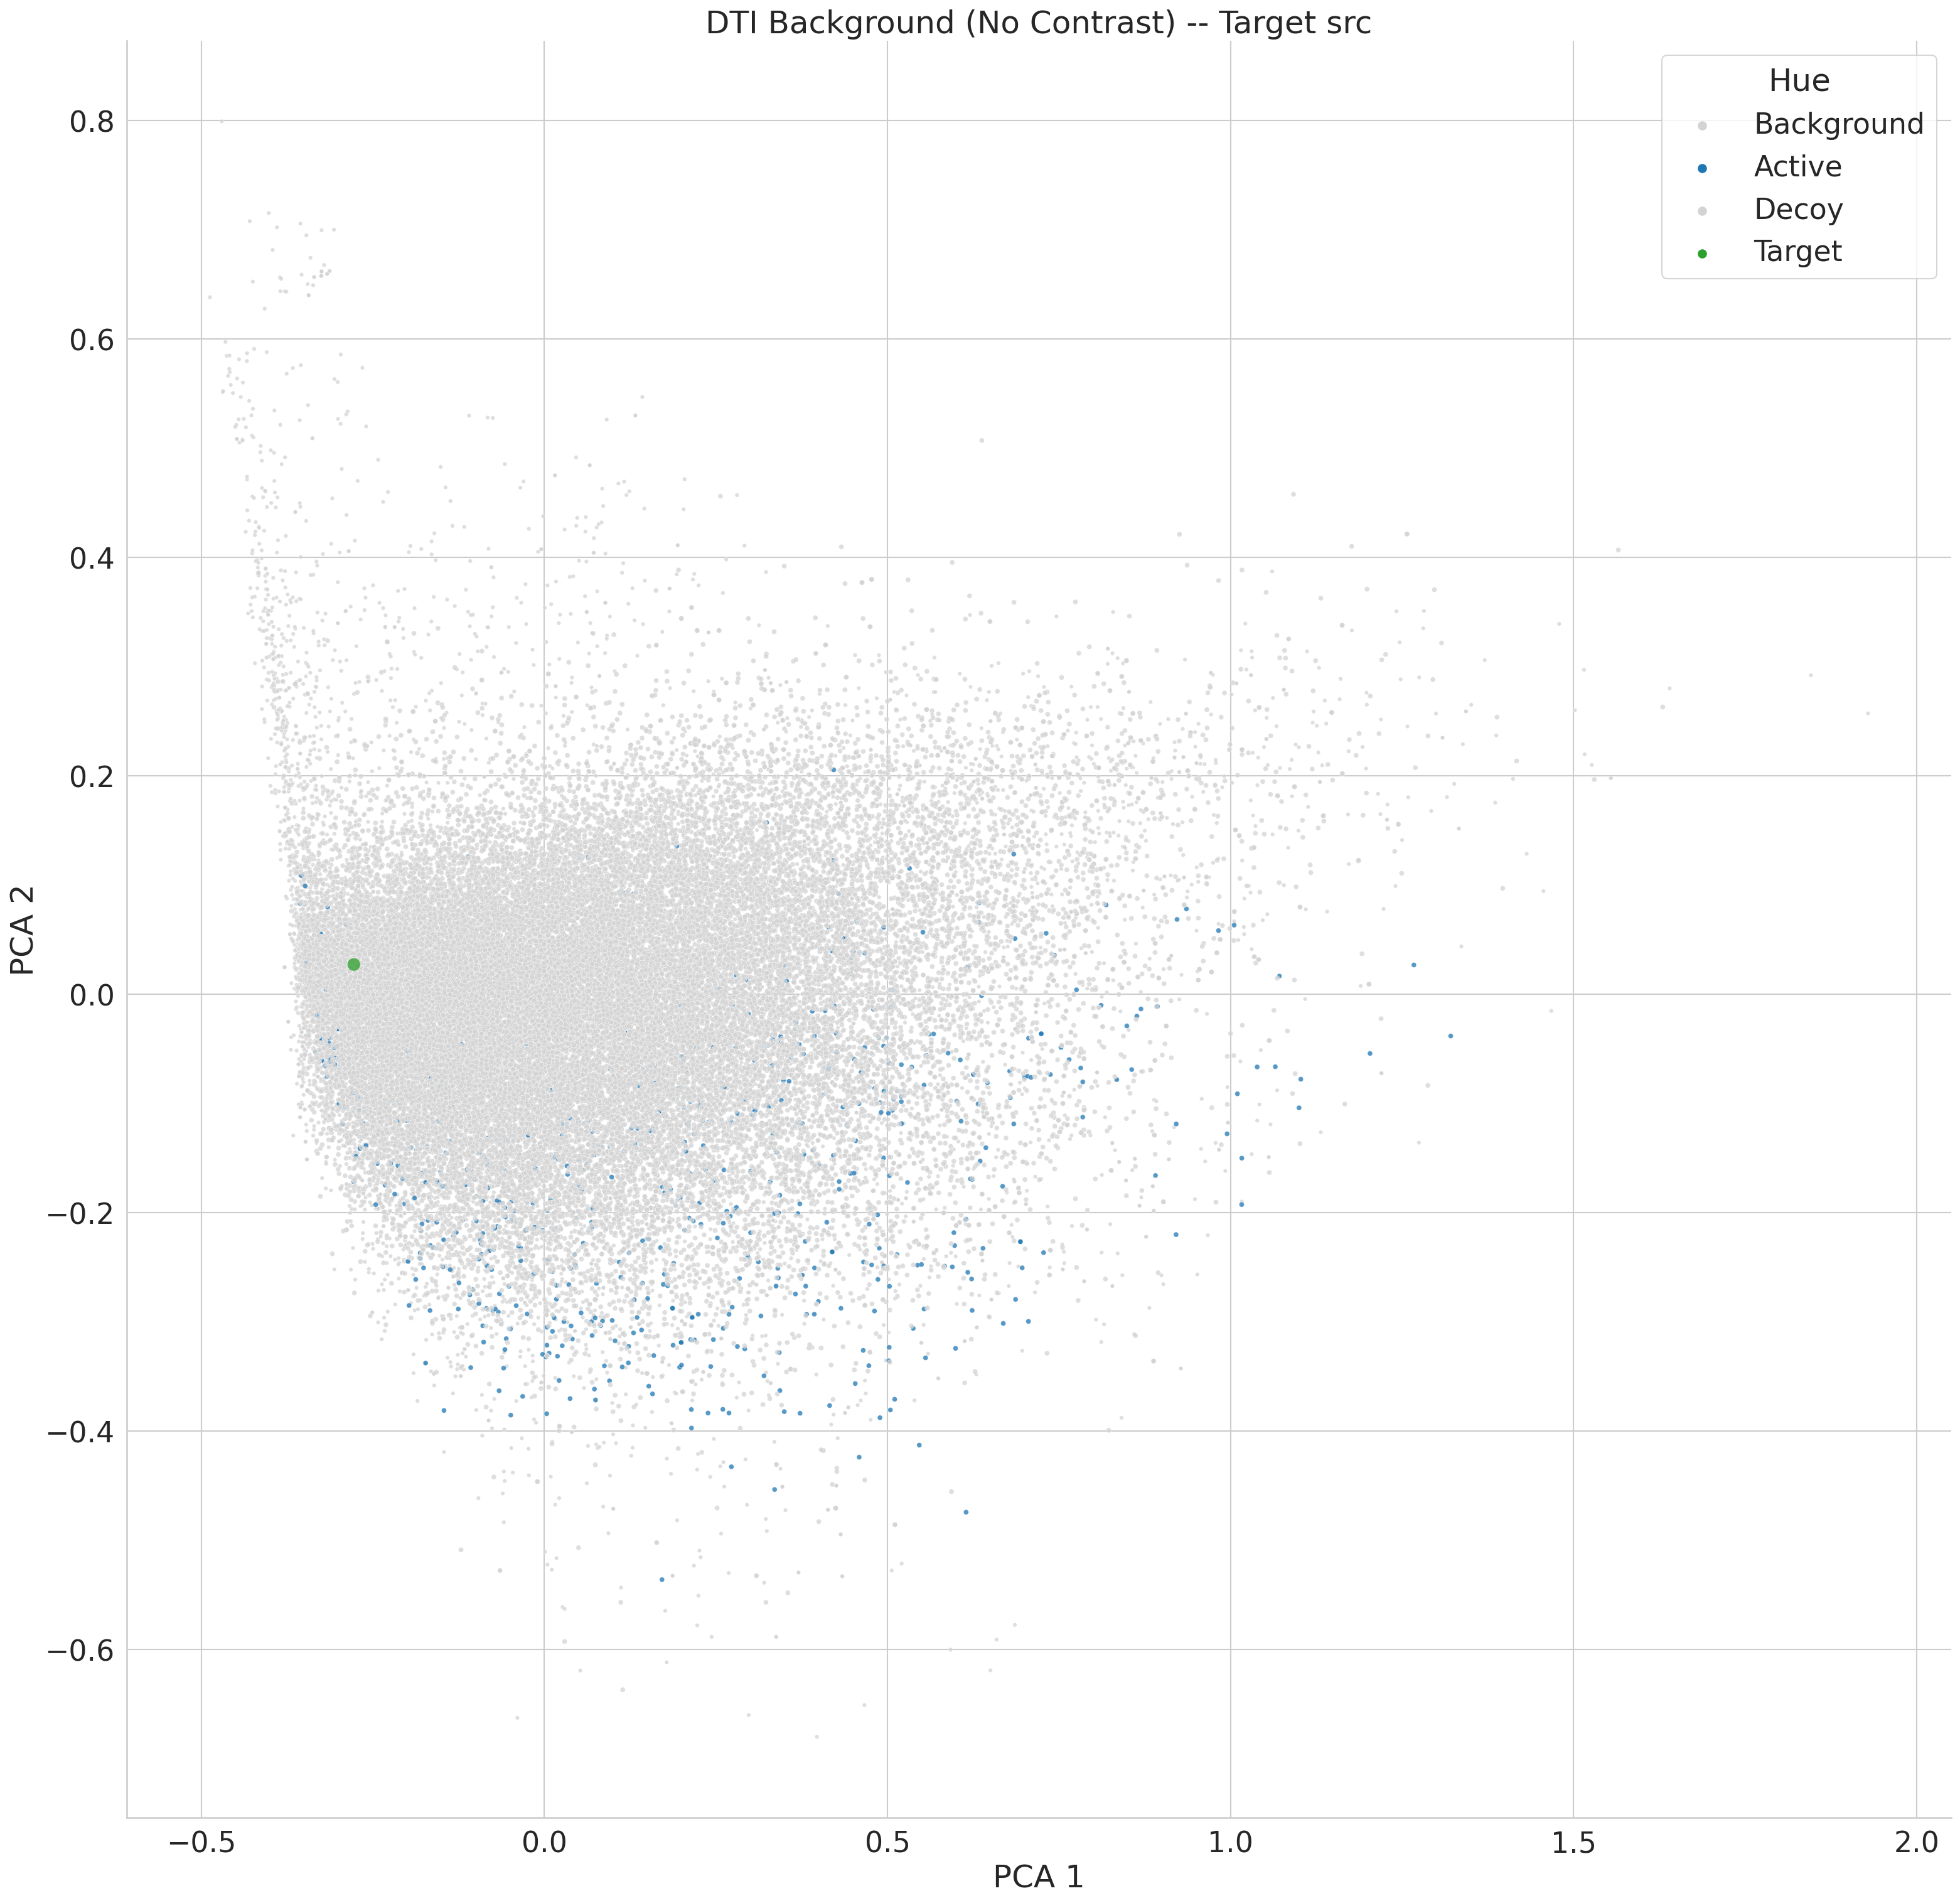

In [205]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(25, 25), dpi=150)

plot_df = pd.DataFrame({
    'PCA 1': np.concatenate([pca_background_nocontrast[:,0], pca_foreground_nocon[:,0]]),
    'PCA 2': np.concatenate([pca_background_nocontrast[:,1], pca_foreground_nocon[:,1]]),
    'Hue': ['Background']*pca_background_nocontrast.shape[0] + ['Active']*len(active_nocon) + ['Decoy']*len(decoy_nocon) + ['Target'],
    'Size': [10]*pca_background_nocontrast.shape[0] + [15]*len(active_nocon)+[15]*len(decoy_nocon) + [100]
})

palette = ['lightgrey',sns.color_palette('tab10')[0],'lightgrey',sns.color_palette('tab10')[2]]

sns.scatterplot(
    data = plot_df,
    x = "PCA 1",
    y = "PCA 2",
    hue = 'Hue',
    s= plot_df['Size'],
    alpha=0.75,
    palette=palette
   )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'DTI Background (No Contrast) -- Target {target}')
sns.despine()
plt.show()

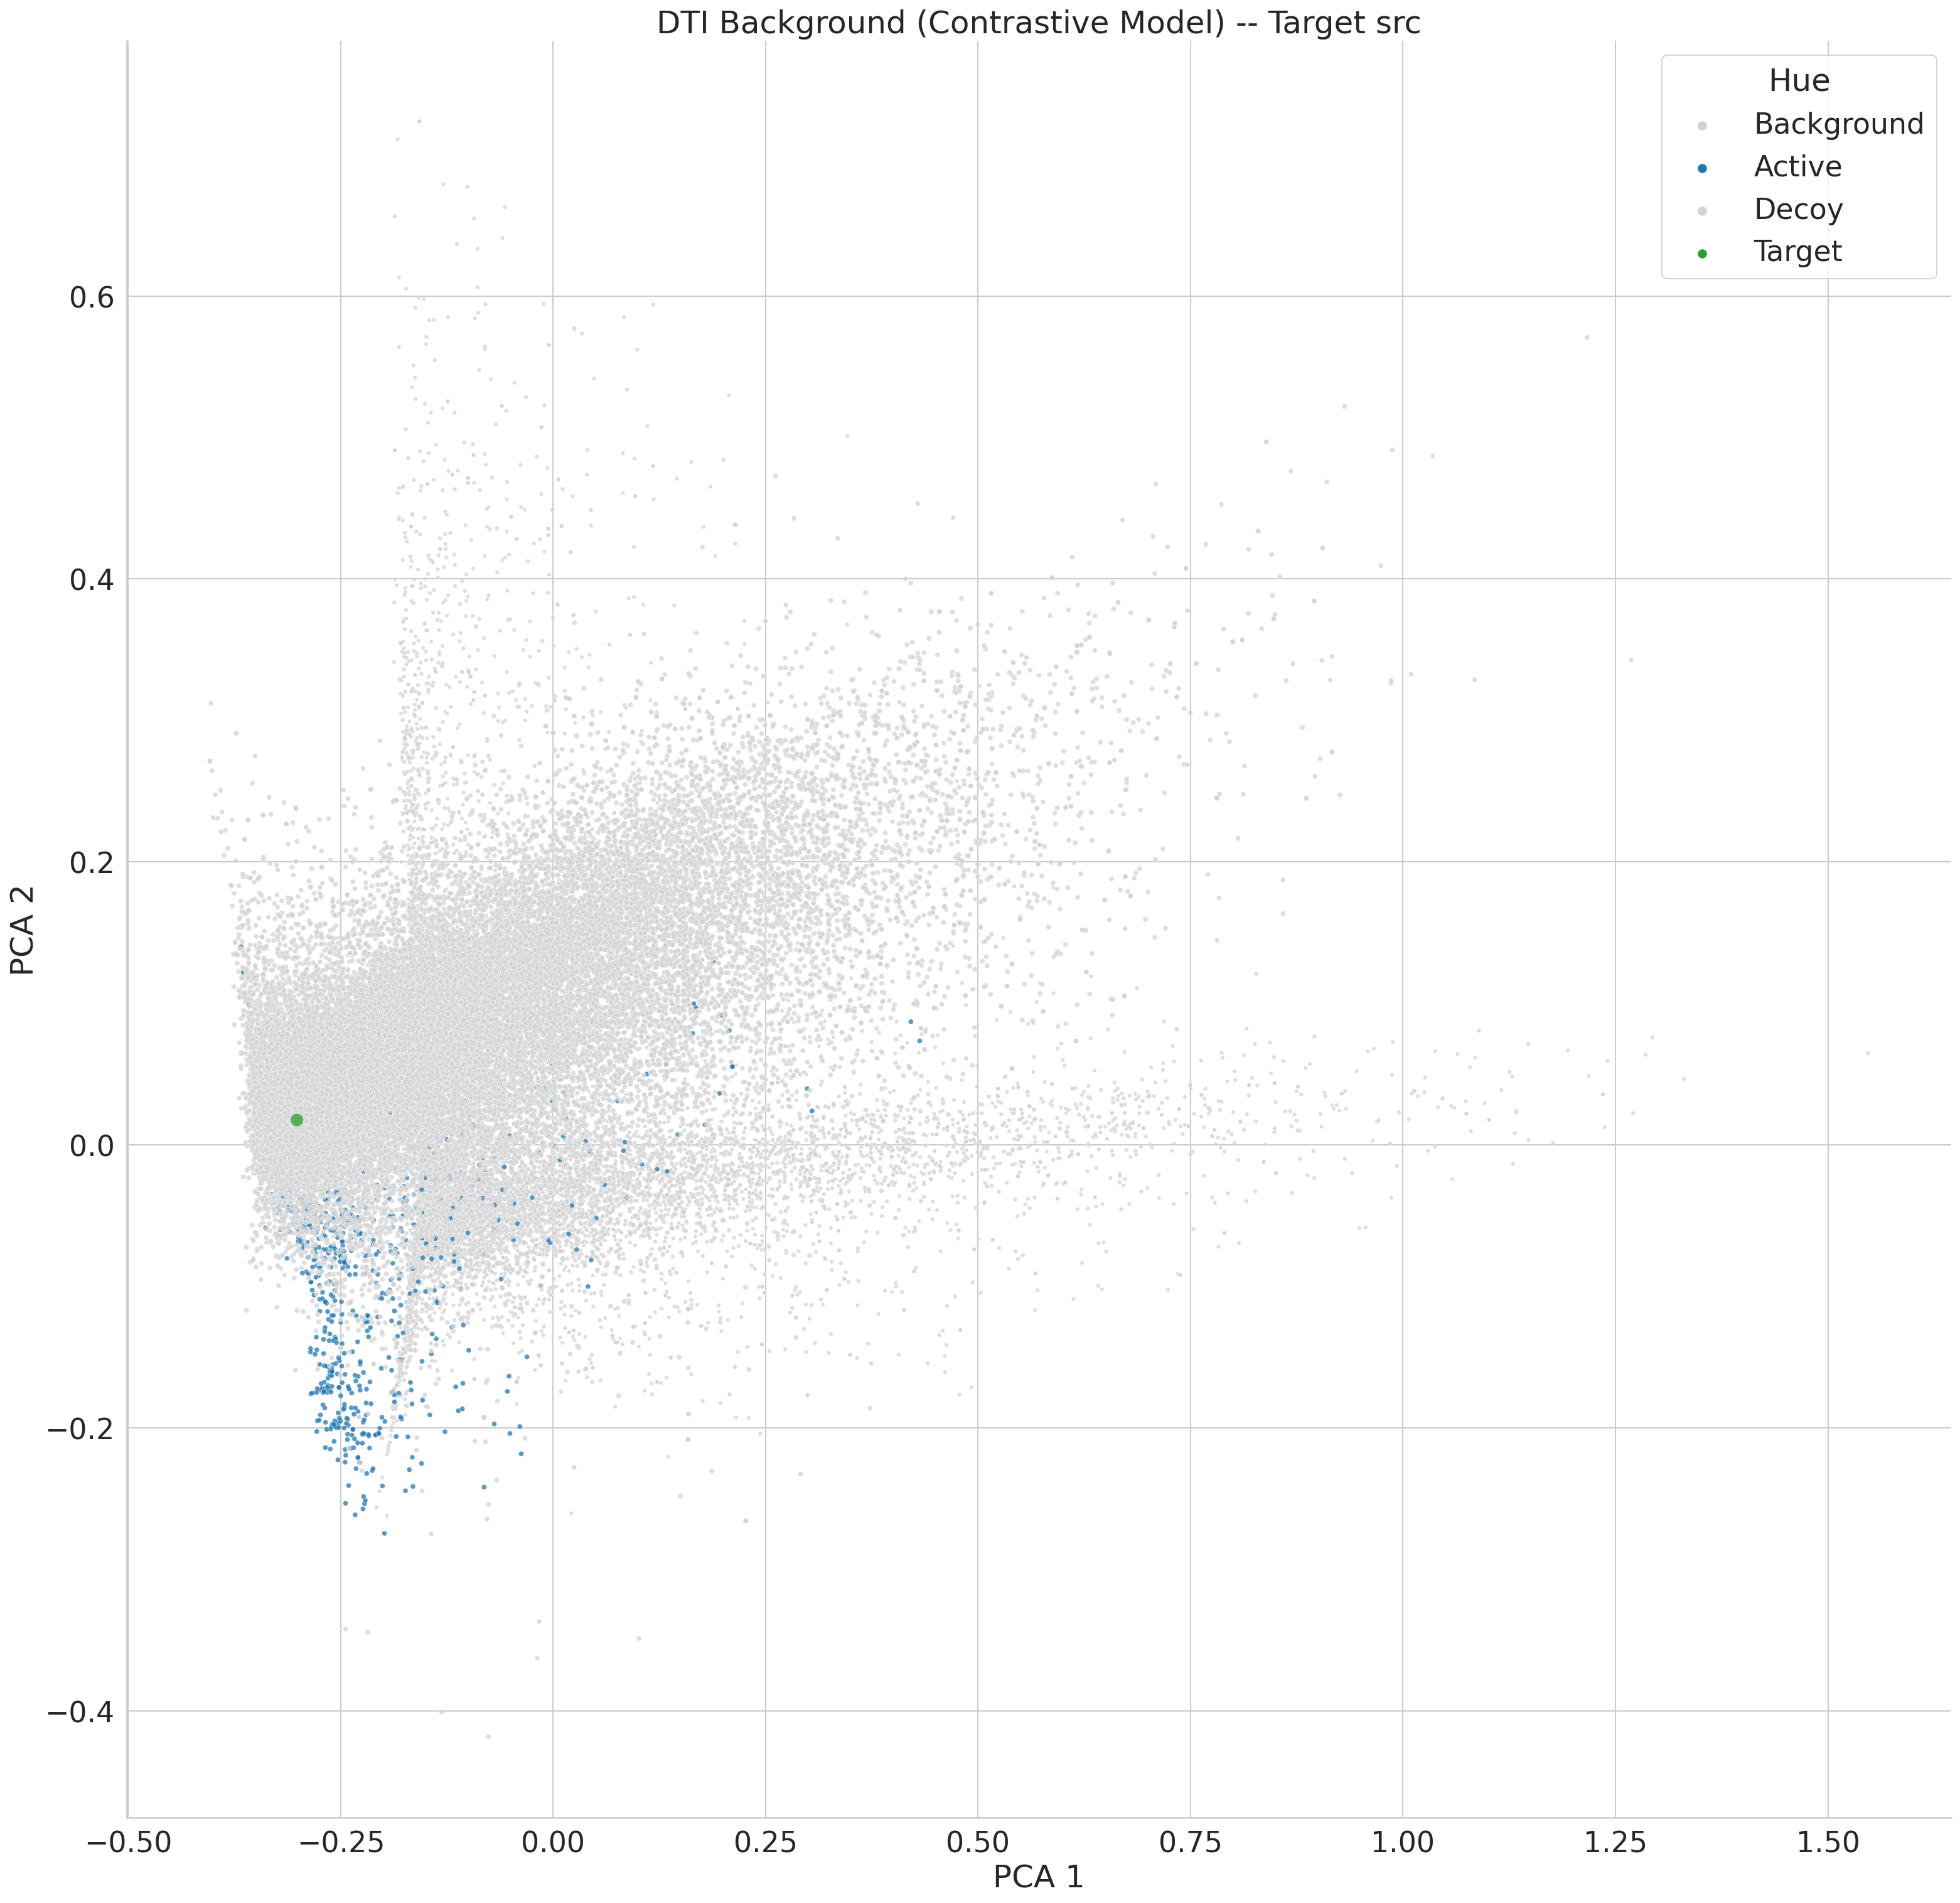

In [204]:
sns.set(style='whitegrid',font_scale=2)
plt.figure(figsize=(25, 25), dpi=150)

plot_df = pd.DataFrame({
    'PCA 1': np.concatenate([pca_background_contrast[:,0], pca_foreground_con[:,0]]),
    'PCA 2': np.concatenate([pca_background_contrast[:,1], pca_foreground_con[:,1]]),
    'Hue': ['Background']*pca_background_contrast.shape[0] + ['Active']*len(active_con) + ['Decoy']*len(decoy_con) + ['Target'],
    'Size': [10]*pca_background_contrast.shape[0] + [15]*len(active_con)+[15]*len(decoy_con) + [100]
})

palette = ['lightgrey',sns.color_palette('tab10')[0],'lightgrey',sns.color_palette('tab10')[2]]

sns.scatterplot(
    data = plot_df,
    x = "PCA 1",
    y = "PCA 2",
    hue = 'Hue',
    s= plot_df['Size'],
    alpha=0.75,
    palette=palette
   )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'DTI Background (Contrastive Model) -- Target {target}')
sns.despine()
plt.show()